In [ ]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

     |████████████████████████████████| 65.9MB 46kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_train["condition"] = df_train["condition"].replace( np.nan, 3)
df_train['train_flag'] = 1
print(df_train.shape)

df_test = pd.read_csv('/content/test.csv')
df_test["condition"] = df_test["condition"].replace( np.nan, 3)
df_test['train_flag'] = 0
df_test['breed_category'] = -1
df_test['pet_category'] = -1
print(df_test.shape)

df_data = pd.concat([df_train,df_test])
print(df_data.shape)
df_data = df_data.reset_index(drop=True)
df_data

(18834, 12)
(8072, 12)
(26906, 12)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2,1
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3.0,Brown,0.15,40.90,15,4,2.0,4,1
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2,1
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
26901,ANSL_66809,2016-02-10 00:00:00,2017-03-10 14:56:00,2.0,Brown,0.82,36.08,13,9,-1.0,-1,0
26902,ANSL_59041,2015-12-07 00:00:00,2018-02-12 00:00:00,0.0,Tan,0.49,27.54,13,9,-1.0,-1,0
26903,ANSL_60034,2015-12-08 00:00:00,2017-01-04 17:19:00,0.0,Black,0.98,37.19,0,7,-1.0,-1,0
26904,ANSL_58066,2016-06-28 00:00:00,2017-07-20 18:19:00,3.0,Black,0.79,23.83,0,2,-1.0,-1,0


In [ ]:
df_data["length(m)"] = df_data["length(m)"]*100   
df_data["condition"] = df_data["condition"].astype("int") 
df_data.head()                                            

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2,Brown Tabby,80.0,7.78,13,9,0.0,1,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1,White,72.0,14.19,13,9,0.0,2,1
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3,Brown,15.0,40.90,15,4,2.0,4,1
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1,White,62.0,17.82,0,1,0.0,2,1
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2,Black,50.0,11.06,18,4,0.0,1,1


In [ ]:
le = LabelEncoder()
df_data["color_type"] = le.fit_transform(df_data["color_type"])
print(df_data.shape)
df_data.head()

(26906, 12)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2,18,80.0,7.78,13,9,0.0,1,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1,53,72.0,14.19,13,9,0.0,2,1
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3,15,15.0,40.90,15,4,2.0,4,1
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1,53,62.0,17.82,0,1,0.0,2,1
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2,2,50.0,11.06,18,4,0.0,1,1


In [ ]:
from datetime import datetime

lt = len(df_data)
for i in range(lt):
    cre = df_data["issue_date"][i]
    splt1=cre.split('-')
    splt2=splt1[2].split(' ')
    splt3=splt2[1].split(':')
    st1 = datetime(int(splt1[0]),int(splt1[1]),int(splt2[0]),int(splt3[0]),int(splt3[1]),int(splt3[2]))

    cre = df_data["listing_date"][i]
    splt1=cre.split('-')
    splt2=splt1[2].split(' ')
    splt3=splt2[1].split(':')
    st2 = datetime(int(splt1[0]),int(splt1[1]),int(splt2[0]),int(splt3[0]),int(splt3[1]),int(splt3[2]))

    if st1>st2:
        df_data["listing_date"][i] , df_data["issue_date"][i] = df_data["issue_date"][i] , df_data["listing_date"][i] 

# df_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from datetime import datetime
df_data["issueyear"] = 0
df_data["issuemonth"] = 0
df_data["issuedate"] = 0

df_data["listyear"] = 0
df_data["listmonth"] = 0
df_data["listdate"] = 0

lt = len(df_data)
for i in range(lt):
    cre = df_data["issue_date"][i]
    splt1=cre.split('-')
    splt2=splt1[2].split(' ')
    splt3=splt2[1].split(':')

    df_data["issueyear"][i] = int(splt1[0])
    df_data["issuemonth"][i] = int(splt1[1])
    df_data["issuedate"][i] = int(splt2[0])


    cre = df_data["listing_date"][i]
    splt1=cre.split('-')
    splt2=splt1[2].split(' ')
    splt3=splt2[1].split(':')
    df_data["listyear"][i] = int(splt1[0])
    df_data["listmonth"][i] = int(splt1[1])
    df_data["listdate"][i] = int(splt2[0])

# df_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
from datetime import datetime
df_data["issueYG"]   = df_data.groupby(["issueyear" ]).ngroup().astype('int')
df_data["listYG"]    = df_data.groupby(["listyear" ]).ngroup().astype('int')
df_data["issueYGMG"] = df_data.groupby(["issueyear" , "issuemonth" ]).ngroup().astype('int')
df_data["listYGMG"]  = df_data.groupby(["listyear" , "listmonth" ]).ngroup().astype('int')
df_data.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag,issueyear,issuemonth,issuedate,listyear,listmonth,listdate,issueYG,listYG,issueYGMG,listYGMG
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2,18,80.0,7.78,13,9,0.0,1,1,2016,7,10,2016,9,21,23,1,211,15
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1,53,72.0,14.19,13,9,0.0,2,1,2013,11,21,2018,12,27,20,3,179,42
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3,15,15.0,40.90,15,4,2.0,4,1,2014,9,28,2016,10,19,21,1,189,16
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1,53,62.0,17.82,0,1,0.0,2,1,2016,12,31,2019,1,25,23,4,216,43
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2,2,50.0,11.06,18,4,0.0,1,1,2017,9,28,2017,11,19,24,2,225,29


In [ ]:
df_data["days"] = 0
df_data["hour"] = 0
df_data["min"]  = 0

lt = len(df_data)
for i in range(lt):
    st = df_data["issue_date"][i]
    splt1=st.split('-')
    splt2=splt1[2].split(' ')
    splt3=splt2[1].split(':')
    st1 = datetime(int(splt1[0]),int(splt1[1]),int(splt2[0]),int(splt3[0]),int(splt3[1]),int(splt3[2]))

    en = df_data["listing_date"][i]
    splt1=en.split('-')
    splt2=splt1[2].split(' ')
    splt3=splt2[1].split(':')
    en1 = datetime(int(splt1[0]),int(splt1[1]),int(splt2[0]),int(splt3[0]),int(splt3[1]),int(splt3[2]))

    diff = en1 - st1
    df_data["days"][i] = int(str(diff).split()[0])//30
    df_data["hour"][i] = int(splt3[0])
    df_data["min"][i]  = int(splt3[1])

df_data.head()






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag,issueyear,issuemonth,issuedate,listyear,listmonth,listdate,issueYG,listYG,issueYGMG,listYGMG,days,hour,min
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2,18,80.0,7.78,13,9,0.0,1,1,2016,7,10,2016,9,21,23,1,211,15,2,16,25
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1,53,72.0,14.19,13,9,0.0,2,1,2013,11,21,2018,12,27,20,3,179,42,62,17,47
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3,15,15.0,40.90,15,4,2.0,4,1,2014,9,28,2016,10,19,21,1,189,16,25,8,24
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1,53,62.0,17.82,0,1,0.0,2,1,2016,12,31,2019,1,25,23,4,216,43,25,18,30
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2,2,50.0,11.06,18,4,0.0,1,1,2017,9,28,2017,11,19,24,2,225,29,1,9,38


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26906 entries, 0 to 26905
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pet_id          26906 non-null  object 
 1   issue_date      26906 non-null  object 
 2   listing_date    26906 non-null  object 
 3   condition       26906 non-null  int64  
 4   color_type      26906 non-null  int64  
 5   length(m)       26906 non-null  float64
 6   height(cm)      26906 non-null  float64
 7   X1              26906 non-null  int64  
 8   X2              26906 non-null  int64  
 9   breed_category  26906 non-null  float64
 10  pet_category    26906 non-null  int64  
 11  train_flag      26906 non-null  int64  
 12  issueyear       26906 non-null  int64  
 13  issuemonth      26906 non-null  int64  
 14  issuedate       26906 non-null  int64  
 15  listyear        26906 non-null  int64  
 16  listmonth       26906 non-null  int64  
 17  listdate        26906 non-null 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


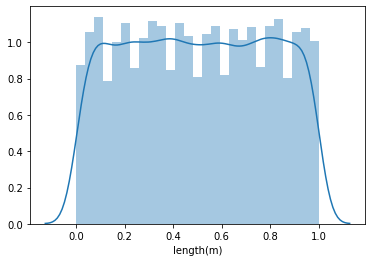

In [ ]:
import seaborn as sns
sns.distplot(df_train['length(m)'])
df_train['length(m)'].plot

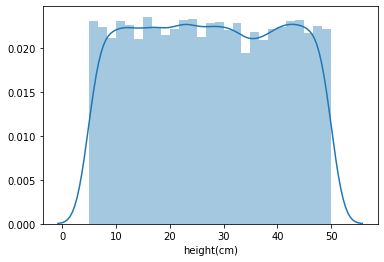

In [ ]:
sns.distplot(df_train['height(cm)'])
df_train['height(cm)'].plot

In [ ]:
df_train.pet_category.value_counts()

2    10621
1     7184
4      941
0       88
Name: pet_category, dtype: int64

In [ ]:
df_train.breed_category.value_counts()

0.0    9000
1.0    8357
2.0    1477
Name: breed_category, dtype: int64

In [ ]:
df_train.isnull().sum()

pet_id            0
issue_date        0
listing_date      0
condition         0
color_type        0
length(m)         0
height(cm)        0
X1                0
X2                0
breed_category    0
pet_category      0
train_flag        0
dtype: int64

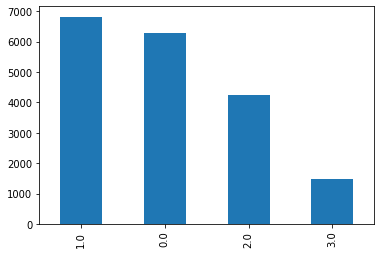

In [ ]:
df_train["condition"].value_counts().plot.bar()

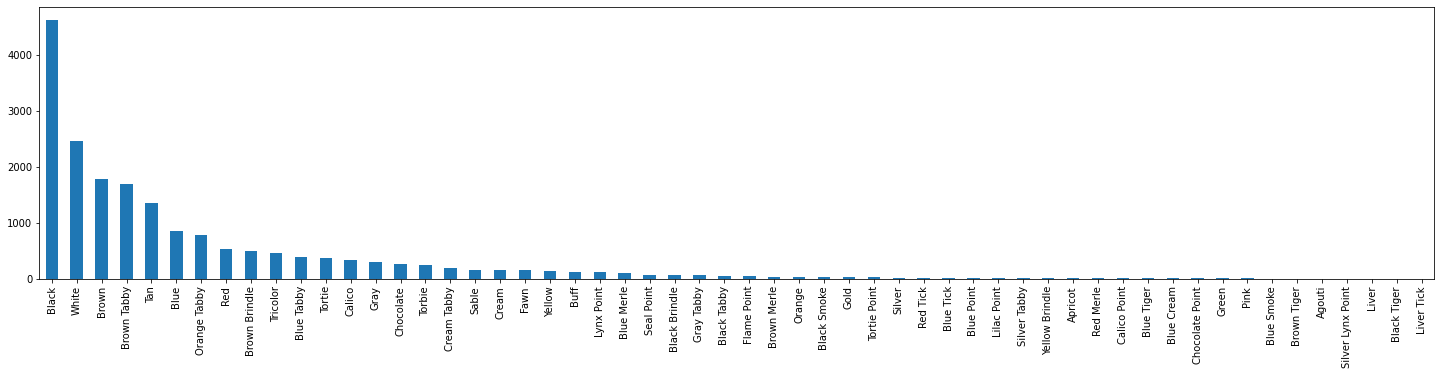

In [ ]:
df_train["color_type"].value_counts().plot.bar(figsize=(25,5))

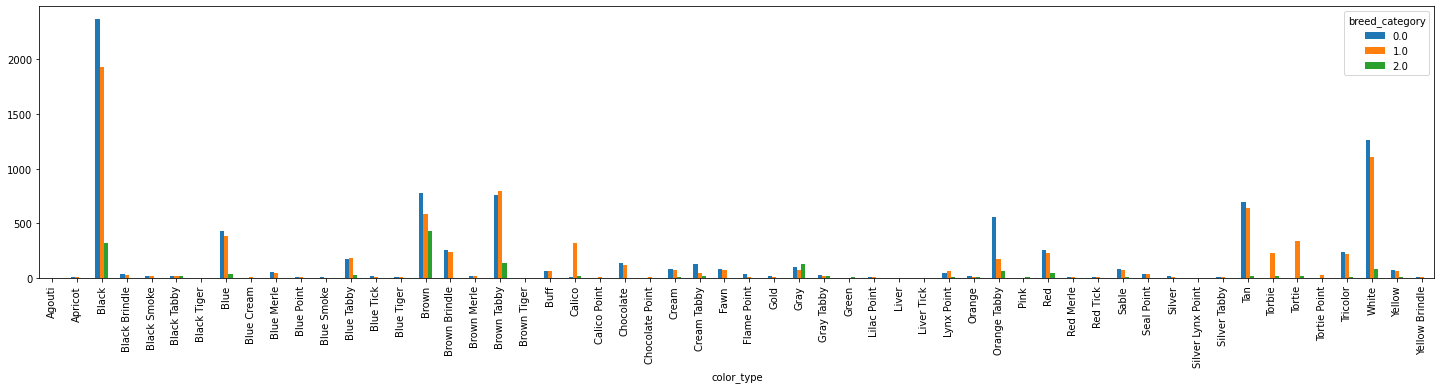

In [ ]:
Ever_Married = pd.crosstab(df_train['color_type'], df_train['breed_category'])
Ever_Married.plot(kind="bar", figsize=(25, 5))
plt.show()


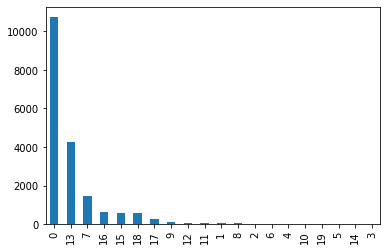

In [ ]:
df_train["X1"].value_counts().plot.bar()

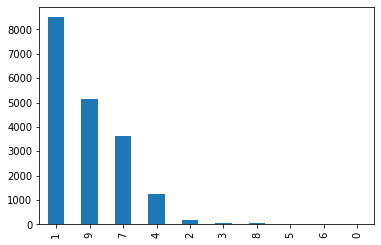

In [ ]:
df_train["X2"].value_counts().plot.bar()

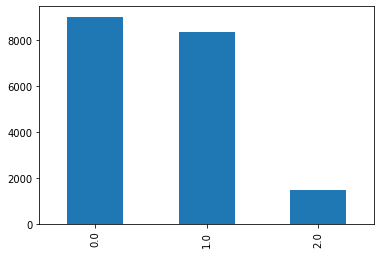

In [ ]:
df_train["breed_category"].value_counts().plot.bar()

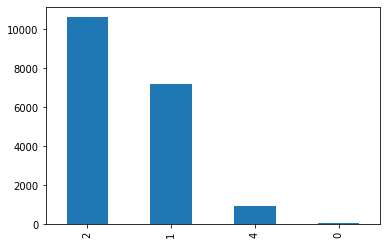

In [ ]:
df_train["pet_category"].value_counts().plot.bar()

In [ ]:
# get values of corelation coefficient and p-value
# [pet_id', 'issue_date', 'listing_date', 'condition','color_type', 'length(m)', 'height(cm)', 'X1', 'X2', 'breed_category','pet_category']
import scipy
print("condition    ", scipy.stats.pearsonr(df_train["condition"],df_train["breed_category"]))
print("color_type   ", scipy.stats.pearsonr(df_data["color_type"],df_data["breed_category"]))
print("length(m)    ", scipy.stats.pearsonr(df_train["length(m)"],df_train["breed_category"]))
print("height(cm)   ", scipy.stats.pearsonr(df_train["height(cm)"],df_train["breed_category"]))
print("X1           ", scipy.stats.pearsonr(df_train["X1"],df_train["breed_category"]))
print("X2           ", scipy.stats.pearsonr(df_train["X2"],df_train["breed_category"]))


condition     (0.10338666775206742, 6.349347926012045e-46)
color_type    (-0.0046717494800562545, 0.44351095811095076)
length(m)     (0.007229081005664604, 0.32117574117746855)
height(cm)    (0.01164685872499623, 0.1099699285579267)
X1            (0.2407288958846845, 1.8247010549611085e-246)
X2            (0.05253040207239441, 5.448452580691977e-13)


In [ ]:
# get values of corelation coefficient and p-value
# [pet_id', 'issue_date', 'listing_date', 'condition','color_type', 'length(m)', 'height(cm)', 'X1', 'X2', 'breed_category','pet_category']
import scipy
print("condition    ", scipy.stats.pearsonr(df_train["condition"],df_train["pet_category"]))
print("color_type   ", scipy.stats.pearsonr(df_data["color_type"],df_data["pet_category"]))
print("length(m)    ", scipy.stats.pearsonr(df_train["length(m)"],df_train["pet_category"]))
print("height(cm)   ", scipy.stats.pearsonr(df_train["height(cm)"],df_train["pet_category"]))
print("X1           ", scipy.stats.pearsonr(df_train["X1"],df_train["pet_category"]))
print("X2           ", scipy.stats.pearsonr(df_train["X2"],df_train["pet_category"]))


condition     (0.19604372652253008, 1.6084126723998781e-162)
color_type    (0.019364370866292266, 0.0014906513205866004)
length(m)     (-0.003999493964179361, 0.5831122349842931)
height(cm)    (0.001975767001457473, 0.7862905518561875)
X1            (-0.032593669367212086, 7.67877739781292e-06)
X2            (-0.03211610455182518, 1.0415483212673577e-05)


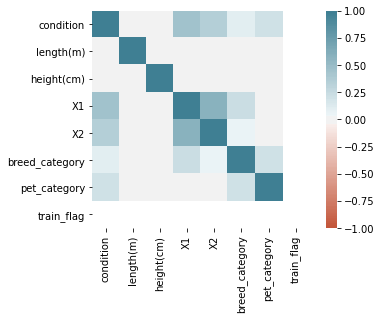

In [ ]:
# get complete heatmap of all corelation coefficients
import seaborn as sns
corr = df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [ ]:
df_data = df_data.sample(frac=1)
train = df_data[df_data["train_flag"] == 1]
test  = df_data[df_data["train_flag"] == 0]
# train = train.reset_index(drop=True)
# test = test.reset_index(drop=True)
print(train.shape , test.shape)
train

(18834, 25) (8072, 25)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag,issueyear,issuemonth,issuedate,listyear,listmonth,listdate,issueYG,listYG,issueYGMG,listYGMG,days,hour,min
10374,ANSL_59330,2018-01-22 00:00:00,2018-10-23 15:40:00,2,2,98.0,8.12,0,7,0.0,2,1,2018,1,22,2018,10,23,25,3,229,40,9,15,40
300,ANSL_55436,2016-12-12 00:00:00,2017-07-03 08:39:00,3,15,26.0,43.10,15,4,2.0,4,1,2016,12,12,2017,7,3,23,2,216,25,6,8,39
8835,ANSL_76221,2017-04-02 00:00:00,2019-04-28 12:41:00,2,53,39.0,17.87,13,9,0.0,2,1,2017,4,2,2019,4,28,24,4,220,46,25,12,41
18380,ANSL_75057,2017-11-01 00:00:00,2018-02-08 17:18:00,0,12,92.0,12.60,0,1,1.0,1,1,2017,11,1,2018,2,8,24,3,227,32,3,17,18
14172,ANSL_61837,2006-09-21 00:00:00,2016-10-12 13:01:00,0,53,57.0,36.99,0,7,1.0,2,1,2006,9,21,2016,10,12,13,1,93,16,122,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14047,ANSL_66713,2017-10-14 00:00:00,2017-12-05 00:00:00,2,23,52.0,30.04,13,9,1.0,2,1,2017,10,14,2017,12,5,24,2,226,30,1,0,0
15704,ANSL_51270,2017-02-10 00:00:00,2019-02-26 18:23:00,1,25,51.0,13.39,0,1,0.0,2,1,2017,2,10,2019,2,26,24,4,218,44,24,18,23
17106,ANSL_52852,2018-06-26 00:00:00,2018-11-04 12:04:00,2,2,15.0,31.18,17,9,0.0,1,1,2018,6,26,2018,11,4,25,3,234,41,4,12,4
13001,ANSL_53801,2017-07-03 00:00:00,2017-10-07 00:00:00,0,53,8.0,17.35,13,9,1.0,1,1,2017,7,3,2017,10,7,24,2,223,28,3,0,0


In [ ]:
test

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag,issueyear,issuemonth,issuedate,listyear,listmonth,listdate,issueYG,listYG,issueYGMG,listYGMG,days,hour,min
21529,ANSL_68733,2016-11-05 00:00:00,2018-11-29 12:18:00,2,15,79.0,15.38,0,1,-1.0,-1,0,2016,11,5,2018,11,29,23,3,215,41,25,12,18
25572,ANSL_52260,2016-10-20 00:00:00,2016-11-17 11:44:00,2,2,86.0,34.62,9,2,-1.0,-1,0,2016,10,20,2016,11,17,23,1,214,17,0,11,44
21175,ANSL_69005,2017-08-04 00:00:00,2017-12-05 19:14:00,0,50,96.0,39.03,0,1,-1.0,-1,0,2017,8,4,2017,12,5,24,2,224,30,4,19,14
20178,ANSL_72311,2005-06-24 00:00:00,2017-07-17 15:33:00,2,18,81.0,23.16,13,9,-1.0,-1,0,2005,6,24,2017,7,17,12,2,78,25,146,15,33
19365,ANSL_71046,2015-06-18 00:00:00,2016-07-17 11:59:00,0,53,47.0,28.93,0,1,-1.0,-1,0,2015,6,18,2016,7,17,22,1,198,13,13,11,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,ANSL_76182,2018-08-27 00:00:00,2018-11-09 12:03:00,2,18,41.0,37.76,0,1,-1.0,-1,0,2018,8,27,2018,11,9,25,3,236,41,2,12,3
26680,ANSL_61508,2015-10-06 00:00:00,2017-10-27 09:00:00,0,18,91.0,18.91,16,9,-1.0,-1,0,2015,10,6,2017,10,27,22,2,202,28,25,9,0
20364,ANSL_69710,2015-12-16 00:00:00,2016-11-19 17:33:00,0,15,56.0,36.66,0,1,-1.0,-1,0,2015,12,16,2016,11,19,22,1,204,17,11,17,33
26607,ANSL_65715,2017-07-21 00:00:00,2018-08-11 19:12:00,2,48,79.0,18.78,0,7,-1.0,-1,0,2017,7,21,2018,8,11,24,3,223,38,12,19,12


In [ ]:
def train_model(X , Y):
    # classifier = LGBMClassifier()
    # param_grid = {"max_depth":[4,6,8,10,-1],
    #       "num_leaves":[7,15,31,63,127],
    #       "min_data_in_leaf":[1,3,5,7,10,25],
    #       "n_estimators":list(range(50,1001,100))}

    # model = RandomizedSearchCV(estimator = classifier,
    #                     param_distributions = param_grid,
    #                     cv = 5,
    #                     n_iter = 10,
    #                     verbose=1000
    #                     )

    # classifier = XGBClassifier(n_jobs = -1)
    # param_grid = {
    #     "n_estimators" : np.arange(100,1200,100),
    #     "max_depth" : np.arange(3,10)
    # }

    # model = RandomizedSearchCV(estimator = classifier,
    #                     param_distributions = param_grid,
    #                     cv = 5,
    #                     n_iter = 10,
    #                     verbose=1000
    #                     )

    # classifier = CatBoostClassifier(verbose=0)
    # param_grid = {
    #     "n_estimators" : np.arange(100,1200,100),
    #     "depth" : np.arange(3,10)
    # }

    # model = RandomizedSearchCV(estimator = classifier,
    #                     param_distributions = param_grid,
    #                     cv = 5,
    #                     n_iter = 10,
    #                     verbose=1000
    #                     )

    # model = CatBoostClassifier(n_estimators=800, depth=5, verbose=0)
    # model = CatBoostClassifier( n_estimators=800, depth=4, verbose=0)
    # model = RandomForestClassifier()
    # model = XGBClassifier(n_estimators=100 , max_depth=8, verbose=0)
    model = LGBMClassifier(max_depth=9 , n_estimators=120 , num_leaves=50)
    model.fit(X , Y)
    return model



def prediction(model , ind):
    if ind == 1:
        drop = copy.deepcopy(col_to_drop1)
    elif ind == 2:
        drop = copy.deepcopy(col_to_drop2)

    X = test.drop(drop , axis=1)


    if ind == 1:
        col1 = test["pet_id"].values
        col2 = model.predict(X)
        return col1 , col2
    elif ind == 2:
        col3 = model.predict(X)
        return col3




In [ ]:
# pet_id	issue_date	listing_date	condition	color_type	length(m)	height(cm)	X1	X2	breed_category	pet_category	train_flag	issueyear	issuemonth	issuedate	listyear	listmonth	listdate	days
# col_to_drop1 = ["pet_id", "issue_date", "listing_date", "breed_category", "length(m)",  "height(cm)", "train_flag", "issuedate", "listdate", "issueYG", "listYG", "issueYGMG", "listYGMG"]
# col_to_drop2 = ["pet_id", "issue_date", "listing_date", "pet_category"  , "length(m)",  "height(cm)", "train_flag", "issuedate", "listdate", "issueYG", "listYG", "issueYGMG", "listYGMG"]

col_to_drop1 = ["pet_id", "issue_date", "listing_date", "breed_category", "length(m)",  "height(cm)", "train_flag", "issuedate", "listdate", "issueyear", "listyear", "issueYGMG", "listYGMG", "listmonth", "min", "hour"]
col_to_drop2 = ["pet_id", "issue_date", "listing_date", "pet_category"  , "length(m)",  "height(cm)", "train_flag", "issuedate", "listdate", "issueyear", "listyear", "issueYGMG", "listYGMG", "listmonth", "min", "hour"]



X1 = train.drop(col_to_drop1 , axis=1)
Y1 = train["breed_category"]
print(X1.shape, Y1.shape)
m1 = train_model(X1 , Y1)

print(m1.score(X1,Y1))
col1 , col2 = prediction(m1 , 1)
print(col1.shape , col2.shape)



drop = copy.deepcopy(col_to_drop1)
X = df_data.drop(drop , axis=1)
df_data["anscol"] = m1.predict(X)
df_data.head()

(18834, 9) (18834,)
0.9426038016353403
(8072,) (8072,)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,train_flag,issueyear,issuemonth,issuedate,listyear,listmonth,listdate,issueYG,listYG,issueYGMG,listYGMG,days,hour,min,anscol
21529,ANSL_68733,2016-11-05 00:00:00,2018-11-29 12:18:00,2,15,79.0,15.38,0,1,-1.0,-1,0,2016,11,5,2018,11,29,23,3,215,41,25,12,18,0.0
10374,ANSL_59330,2018-01-22 00:00:00,2018-10-23 15:40:00,2,2,98.0,8.12,0,7,0.0,2,1,2018,1,22,2018,10,23,25,3,229,40,9,15,40,0.0
300,ANSL_55436,2016-12-12 00:00:00,2017-07-03 08:39:00,3,15,26.0,43.10,15,4,2.0,4,1,2016,12,12,2017,7,3,23,2,216,25,6,8,39,2.0
8835,ANSL_76221,2017-04-02 00:00:00,2019-04-28 12:41:00,2,53,39.0,17.87,13,9,0.0,2,1,2017,4,2,2019,4,28,24,4,220,46,25,12,41,1.0
25572,ANSL_52260,2016-10-20 00:00:00,2016-11-17 11:44:00,2,2,86.0,34.62,9,2,-1.0,-1,0,2016,10,20,2016,11,17,23,1,214,17,0,11,44,0.0


In [ ]:
train = df_data[df_data["train_flag"] == 1]
test  = df_data[df_data["train_flag"] == 0]
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print(train.shape , test.shape)


X2 = train.drop(col_to_drop2 , axis=1)
Y2 = train["pet_category"]
print(X2.shape, Y2.shape)
m2 = train_model(X2 , Y2)


print(m2.score(X2,Y2))
col3 =  prediction(m2 , 2)
print(col3.shape)



# col4 = []
# if col3.shape == (len(df_test),1):
#     for i in range(len(df_test)):
#         col4.append(col3[i][0])
#     col3 = copy.deepcopy(col4)
# print(np.array(col3).shape)

# col5 = []
# if col2.shape == (len(df_test),1):
#     for i in range(len(df_test)):
#         col5.append(col2[i][0])
#     col2 = copy.deepcopy(col5)
# print(np.array(col2).shape)

(18834, 26) (8072, 26)
(18834, 10) (18834,)
0.9341085271317829
(8072,)


In [ ]:
c1 , c2 , c3 = [] , [] , []
df_test = pd.read_csv("/content/test.csv")
idclear = df_test[df_test["condition"].isnull()]["pet_id"].tolist()

lt = len(col1)
for i in range(lt):
    if col1[i] in idclear:
        c1.append(col1[i])
        c2.append(2)
        c3.append(col3[i])
    else:
        c1.append(col1[i])
        c2.append(col2[i])
        c3.append(col3[i])







dict = {'pet_id': c1, 'breed_category': c2 , 'pet_category':c3} 
df_fin = pd.DataFrame(dict) 

filename = "sub.csv"

df_fin.to_csv(filename , index=False)
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>